### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import time
import warnings
from sklearn.metrics import classification_report

import re

2025-05-22 18:18:15.911144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 18:18:15.931440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747927095.948544 1788972 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747927095.953571 1788972 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747927095.966610 1788972 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Upload dataset

In [2]:
# Original Dataset review
original_df_train = pd.read_csv('./IMDB_Dataset.csv')


In [3]:
original_df_train


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


### Data Preprocessing Step

In [4]:
# The first line has been made into a heading for readability.
original_df_train.rename(columns={'review': 'text', 'sentiment': 'label'}, inplace=True)


In [5]:
original_df_train

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [6]:
original_df_train['label'] = original_df_train['label'].map({"positive": 0, "negative": 1})


In [7]:
original_df_train

,text,label
0,One of the other reviewers has mentioned that ...,0
1,A wonderful little production. <br /><br />The...,0
2,I thought this was a wonderful way to spend ti...,0
3,Basically there's a family where a little boy ...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",0
...,...,...
49995,I thought this movie did a down right good job...,0
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",1
49997,I am a Catholic taught in parochial elementary...,1
49998,I'm going to have to disagree with the previou...,1


In [8]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # removing URL
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", text)  # cleaning special character
    text = re.sub(r"\s{2,}", " ", text)  # remove extra space
    return text.strip()

In [9]:
original_df_train['text'] = original_df_train['text'].apply(clean_text)


In [10]:
print(original_df_train.isnull().sum())  # Checking for null value
print(original_df_train.describe())

text     0
label    0
dtype: int64
              label
count  50000.000000
mean       0.500000
std        0.500005
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000


In [11]:
original_df_train['text'].iloc[10]

"Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines br br At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore br br Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest br br I imagine this film would appeal to a stoner who is currently partaking br br For something similar but better try Brother from another planet"

In [12]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(original_df_train["text"],
                                                                      original_df_train["label"],
                                                                      test_size=0.2, random_state=42)


In [66]:
train_texts

39087    That's what I kept asking myself during the ma...
30893    I did not watch the entire movie I could not w...
45278    A touching love story reminiscent of In the Mo...
16398    This latter day Fulci schlocker is a totally a...
13653    First of all, I firmly believe that Norwegian ...
                               ...                        
11284    `Shadow Magic' recaptures the joy and amazemen...
44732    I found this movie to be quite enjoyable and f...
38158    Avoid this one! It is a terrible movie So what...
860      This production was quite a surprise for me I ...
15795    This is a decent movie Although little bit sho...
Name: text, Length: 40000, dtype: object

### Tokenization and Training

In [13]:
vocab_size = 10000        # Maximum number of words to keep
max_length = 200          # Max review length (in words)
oov_token = "<OOV>"    # Out-of-vocabulary token for unseen words
embedding_dim = 64        # Dimension of embedding vector
trunc_type='post'
padding_type='post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts)
#tokenizer.fit_on_texts(test_texts)

In [14]:
tokenizer.document_count

40000

In [15]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [16]:
train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)


In [17]:
# converting the labels to numpy series
train_labels_np = train_labels.to_numpy()  # veya train_labels.values
test_labels_np  = test_labels.to_numpy()


train_ds = TensorDataset(
    torch.LongTensor(train_padded),
    torch.FloatTensor(train_labels_np)
)
test_ds = TensorDataset(
    torch.LongTensor(test_padded),
    torch.FloatTensor(test_labels_np)
)


In [18]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

#### LSTM model desining and hyperparameters

In [67]:
vocab_size    = 10000      
embed_dim     = 64
hidden_dim    = 128
n_layers      = 4
bidirectional = True
dropout       = 0.2
lr            = 1e-4
epochs        = 20

In [68]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 n_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        fc_in = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_in, 1)
        
    def forward(self, x):
        x, _ = self.embedding(x), None            # [B, T] → [B, T, E]
        lstm_out, _ = self.lstm(x)                # [B, T, H*D]
        
        if self.lstm.bidirectional:
            h_fwd = lstm_out[:, -1, :self.lstm.hidden_size]
            h_bwd = lstm_out[:,  0, self.lstm.hidden_size:]
            h = torch.cat([h_fwd, h_bwd], dim=1)
        else:
            h = lstm_out[:, -1, :]
        h = self.dropout(h)
        return torch.sigmoid(self.fc(h)).squeeze()


In [70]:
model= LSTMClassifier(vocab_size, embed_dim, hidden_dim,
                           n_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


#### LSTM training

In [71]:
for epoch in range(1, epochs+1):
    model.train()
    train_loss, train_acc = 0.0, 0.0
    for X, y in tqdm(train_loader,desc=f"Epoch {epoch}/{epochs} [Train]", leave=False):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss  = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc  += ((preds>=0.5).float() == y).float().mean().item()
    train_loss /= len(train_loader)
    train_acc  /= len(train_loader)
    
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for X, y in tqdm(test_loader,desc=f"Epoch {epoch}/{epochs} [Valid]",leave=False):
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss  = criterion(preds, y)
            val_loss += loss.item()
            val_acc  += ((preds>=0.5).float() == y).float().mean().item()
    val_loss /= len(test_loader)
    val_acc  /= len(test_loader)
    
    print(f"Epoch {epoch:02d} — "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 01 — Train Loss: 0.6932, Train Acc: 0.5005 | Val Loss: 0.6933, Val Acc: 0.4961


Epoch 02 — Train Loss: 0.6932, Train Acc: 0.5000 | Val Loss: 0.6932, Val Acc: 0.4961


Epoch 03 — Train Loss: 0.6932, Train Acc: 0.4982 | Val Loss: 0.6932, Val Acc: 0.4961


Epoch 04 — Train Loss: 0.6931, Train Acc: 0.5039 | Val Loss: 0.6931, Val Acc: 0.4961


Epoch 05 — Train Loss: 0.6931, Train Acc: 0.5040 | Val Loss: 0.6931, Val Acc: 0.4961


Epoch 06 — Train Loss: 0.6931, Train Acc: 0.5041 | Val Loss: 0.6931, Val Acc: 0.4961


Epoch 07 — Train Loss: 0.6930, Train Acc: 0.5079 | Val Loss: 0.6930, Val Acc: 0.5035


Epoch 08 — Train Loss: 0.6930, Train Acc: 0.5079 | Val Loss: 0.6930, Val Acc: 0.5108


Epoch 09 — Train Loss: 0.6930, Train Acc: 0.5128 | Val Loss: 0.6930, Val Acc: 0.5225


Epoch 10 — Train Loss: 0.6930, Train Acc: 0.5120 | Val Loss: 0.6929, Val Acc: 0.5322


Epoch 11 — Train Loss: 0.6929, Train Acc: 0.5154 | Val Loss: 0.6929, Val Acc: 0.5354


Epoch 12 — Train Loss: 0.6928, Train Acc: 0.5204 | Val Loss: 0.6928, Val Acc: 0.5370


Epoch 13 — Train Loss: 0.6928, Train Acc: 0.5241 | Val Loss: 0.6928, Val Acc: 0.5409


Epoch 14 — Train Loss: 0.6928, Train Acc: 0.5212 | Val Loss: 0.6927, Val Acc: 0.5436


Epoch 15 — Train Loss: 0.6926, Train Acc: 0.5312 | Val Loss: 0.6926, Val Acc: 0.5452


Epoch 16 — Train Loss: 0.6926, Train Acc: 0.5342 | Val Loss: 0.6924, Val Acc: 0.5505


Epoch 17 — Train Loss: 0.6924, Train Acc: 0.5403 | Val Loss: 0.6923, Val Acc: 0.5479


Epoch 18 — Train Loss: 0.6922, Train Acc: 0.5449 | Val Loss: 0.6921, Val Acc: 0.5500


Epoch 19 — Train Loss: 0.6920, Train Acc: 0.5461 | Val Loss: 0.6918, Val Acc: 0.5511


Epoch 20 — Train Loss: 0.6917, Train Acc: 0.5519 | Val Loss: 0.6914, Val Acc: 0.5513


In [44]:
## save model
!mkdir lstm_imdb_models
MODEL_PATH = "lstm_imdb_models/lstm_classifier_2.pt"
torch.save(model, MODEL_PATH)
print(f"Model kaydedildi → {MODEL_PATH}")

mkdir: cannot create directory ‘lstm_imdb_models’: File exists
Model kaydedildi → lstm_imdb_models/lstm_classifier_2.pt


In [ ]:
## upload model and eval with state_dict format
model = LSTMClassifier(
    vocab_size, embed_dim, hidden_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

model.eval()

In [45]:
# without statedict format
model = torch.load("lstm_imdb_models/lstm_classifier_2.pt", map_location=device)


/tmp/ipykernel_1788972/304414613.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("lstm_imdb_models/lstm_classifier_2.pt", map_location=device)


Accuracy : 0.8574
Precision: 0.8800
Recall   : 0.8250
F1-Score : 0.8516
Confusion Matrix:
 [[4481  558]
 [ 868 4093]]


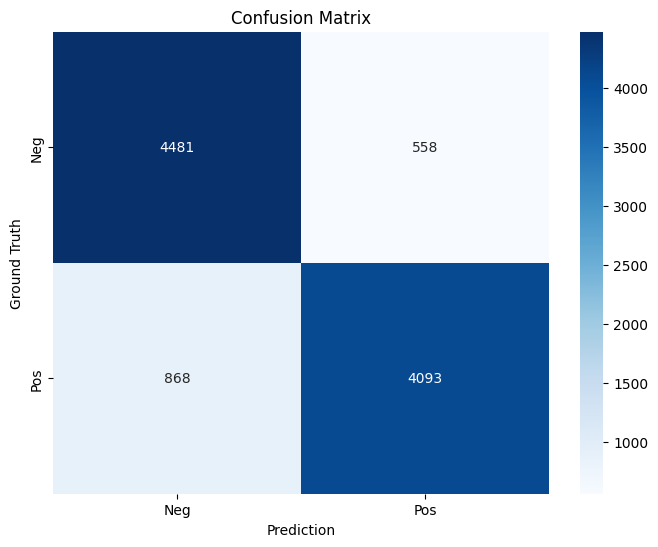

In [59]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        preds = model(X)
        # 0.5 eşik ile ikili sınıf tahmini
        preds = (preds.cpu().numpy() >= 0.5).astype(int)
        all_preds.extend(preds)
        all_labels.extend(y.numpy().astype(int))

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# 4) Metrikleri hesapla
acc   = accuracy_score(all_labels, all_preds)
prec  = precision_score(all_labels, all_preds)
rec   = recall_score(all_labels, all_preds)
f1    = f1_score(all_labels, all_preds)
cm    = confusion_matrix(all_labels, all_preds)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

# 5) Confusion Matrix’i görselleştir (opsiyonel)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Neg","Pos"],
            yticklabels=["Neg","Pos"])
plt.xlabel("Prediction")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix")
plt.show()

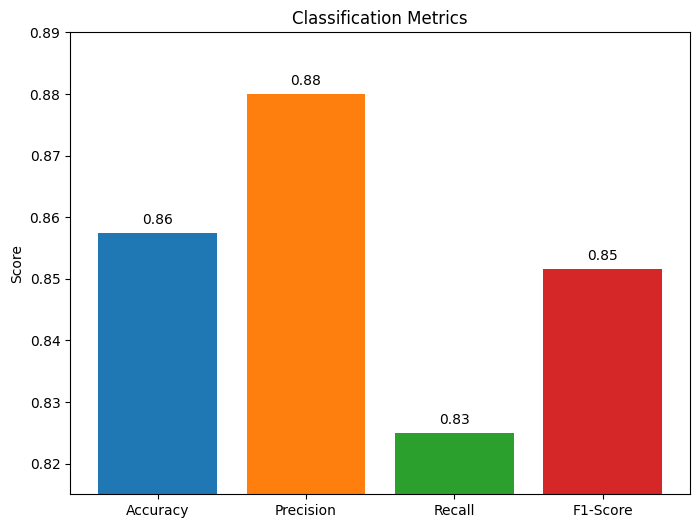

In [57]:
metrics = {
    "Accuracy" : acc,
    "Precision": prec,
    "Recall"   : rec,
    "F1-Score" : f1
}

# Dinamik y-ekseni aralığı: en düşük değerin hemen altından en yüksek değerin biraz üstüne
values = list(metrics.values())
min_val, max_val = min(values), max(values)
margin = 0.01  # %5 marjin
ymin = max(min_val - margin, 0)
ymax = min(max_val + margin, 1.0)

# Renk paleti (4 farklı renk)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

plt.figure(figsize=(8,6))
bars = plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.ylim(ymin, ymax)
plt.ylabel("Score")
plt.title("Classification Metrics")

# Her bar'ın tepesine değer ekleyelim
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.001,
        f"{height:.2f}",
        ha="center",
        va="bottom"
    )

plt.show()

### Calculation of Metrics

In [ ]:
from torch.utils.data import DataLoader
from datasets import Dataset
import numpy as np
from tqdm import tqdm
#test_tokenized = test_tokenized.rename_columns({"label": "labels"})
testing_dataloader = DataLoader(test_tokenized, batch_size=128, shuffle=False)

model.eval()
preds = []
labels = []

with torch.no_grad():
    for batch in tqdm(testing_dataloader,desc="Prediction Progress",unit= "batch"):
        inputs = {k:v.to("cuda") for k,v in batch.items() if k != "label"}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits,dim=-1).cpu().numpy()

        preds.extend(predictions)
        labels.extend(batch["label"].cpu().numpy())

preds = np.array(preds)
labels = np.array(labels)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
# Accuracy 
accuracy = accuracy_score(labels, preds)

# Precision, Recall, F1-score(average="binary" for 2 class )
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

# Confusion Matrix 
conf_matrix = confusion_matrix(labels, preds)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 📌 **Confusion Matrix Visualization**
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 📌 **Precision - Recall - F1 Score Bar Chart**
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Evaluation Metrics")
plt.show()

### Manuel Testing 

In [ ]:
test_sentence = ["very good"]
inputs = tokenizer(test_sentence, padding=True, truncation=True, return_tensors="pt", max_length=512).to("cuda")
with torch.no_grad():
    output_of_manuel = model(**inputs)

predictions_of_manuel = torch.argmax(output_of_manuel.logits,dim=-1)

for sentence,prediction_of_manuel in zip(test_sentence,predictions_of_manuel):
    sentiment = "Negative" if prediction_of_manuel.item() == 1 else "Positive"
    print(f"Sentence: '{sentence}' => Sentiment: {sentiment}")

In [ ]:
print(prediction_of_manuel)

In [ ]:
# Cross data validation amazon to imdb model , otherwise.
# bir de hatalı yapanlarda bir bias var mı hata ayıklama,
# görselleştirmeyi düzenlemek gerekiyo, detaylı gözüksün değerler.
# 